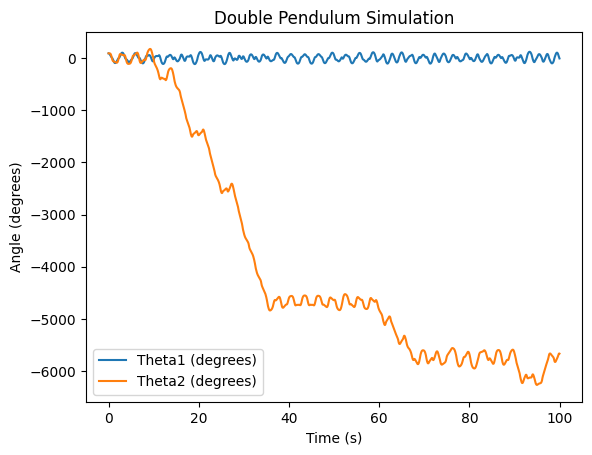

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians, degrees

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Physical constants
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

# Derivative function for the double pendulum system
def f(r, t, g, L1, L2, m1, m2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    # Equations of motion for the double pendulum
    ftheta1 = omega1
    fomega1 = (
        -g * (2 * m1 + m2) * sin(theta1)
        - m2 * g * sin(theta1 - 2 * theta2)
        - 2 * sin(theta1 - theta2) * m2 * (omega2 ** 2 * L2 + omega1 ** 2 * L1 * cos(theta1 - theta2))
    ) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (
        2 * sin(theta1 - theta2) * (omega1 ** 2 * L1 * (m1 + m2)
        + g * (m1 + m2) * cos(theta1)
        + omega2 ** 2 * L2 * m2 * cos(theta1 - theta2))
    ) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return np.array([ftheta1, fomega1, ftheta2, fomega2], float)

# Simulation parameters
a = 0.0  # Start time
b = 100  # End time
N = 10000  # Number of time steps
h = (b - a) / N  # Time step size

# Time points
tpoints = np.arange(a, b, h)

# Pre-allocate arrays for theta1 and theta2
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)

# Input initial conditions in degrees
theta1_deg = 90
omega1_deg = 0
theta2_deg = 90
omega2_deg = 0

# Convert initial conditions to radians for computation
q = np.array([radians(theta1_deg), radians(omega1_deg), radians(theta2_deg), radians(omega2_deg)], float)

# Runge-Kutta 4th order method loop
for i, t in enumerate(tpoints):
    # Store the angles in degrees for plotting
    theta1_points[i] = degrees(q[0])  # Convert radians to degrees
    theta2_points[i] = degrees(q[2])  # Convert radians to degrees

    # RK4 coefficients
    k1 = h * f(q, t, g, L1, L2, m1, m2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, g, L1, L2, m1, m2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, g, L1, L2, m1, m2)
    k4 = h * f(q + k3, t + h, g, L1, L2, m1, m2)

    # Update the state vector
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Plotting
plt.plot(tpoints[0:10000], theta1_points[0:10000], label='Theta1 (degrees)')
plt.plot(tpoints[0:10000], theta2_points[0:10000], label='Theta2 (degrees)')
plt.title("Double Pendulum Simulation")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.show()

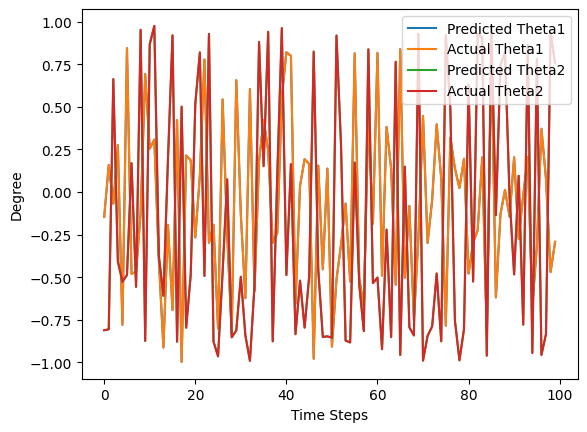

In [2]:
# Combine Data
data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

# Load data
data = np.load('pendulum_data.npy')
theta1_points = data[:, 0]  # Theta1 data
theta2_points = data[:, 1]  # Theta2 data

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)

#Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Hyperparameters
SEQ_LENGTH = 64
POLY_DEGREE = 2

# Create sequences
X, y = create_sequences(data_normalized, SEQ_LENGTH)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Fit the scalers on the training data
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 2 * SEQ_LENGTH))
X_test_scaled = scaler_X.transform(X_test.reshape(-1, 2 * SEQ_LENGTH))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Apply feature mapping
poly = PolynomialFeatures(degree=POLY_DEGREE)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_poly, y_train_scaled)
predictions_scaled = model.predict(X_test_poly)

# Inverse transform
predictions_inverse = scaler_y.inverse_transform(predictions_scaled)
y_test_inverse = scaler_y.inverse_transform(y_test_scaled)

#Plot predicted vs actual angles
plt.plot(predictions_inverse[0:100, 0], label='Predicted Theta1')
plt.plot(y_test_inverse[0:100, 0], label='Actual Theta1')
plt.plot(predictions_inverse[0:100, 1], label='Predicted Theta2')
plt.plot(y_test_inverse[0:100, 1], label='Actual Theta2')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

# RMSE and R^2 score
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
r2 = r2_score(y_test_inverse, predictions_inverse)
print(f'RMSE: {rmse:.10f}')
print(f'R^2 Score: {r2:.10f}')